In [ ]:
%pip install -U imbalanced-learn

In [113]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os 
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
 


In [114]:

colonne_players = ['height_in_cm', 'position', 'player_id', 'date_of_birth', 'last_season']
colonne_app = ['minutes_played', 'assists', 'goals', 'red_cards', 'yellow_cards', 'player_id', 'competition_id']

In [115]:
#carichiamo i dataframe con i csv che ci servono per il join per il clustering, con le colonne

df_appearances = pd.read_csv(r"C:\Users\nicol\OneDrive\Desktop\MAGISTRALE\DATA SCIENCE\Python\DataScience-Python\csv_post_etl\appearances_post.csv", usecols=colonne_app)
df_players = pd.read_csv(r"C:\Users\nicol\OneDrive\Desktop\MAGISTRALE\DATA SCIENCE\Python\DataScience-Python\csv_post_etl\players_post.csv", usecols=colonne_players)

In [116]:
# calcoliamo per ogni giocatore la sua età, andando a creare una nuova colonna nella tabella players


data_attuale = datetime.now()

# elimina i valori nulli su data di nascita

df_players.dropna(subset=['date_of_birth'], inplace=True)

df_players['date_of_birth'] = pd.to_datetime(df_players['date_of_birth'])

df_players['eta'] = ((data_attuale - df_players['date_of_birth']).dt.days / 365.25).astype(int)


In [117]:
# creiamo una colonna che ci dice se il calciatore e ritirato 1: non ritirato, 0 ritirato

# Creazione della nuova colonna 'ritirato'
df_players['ritirato'] = df_players['last_season'].apply(lambda x: 1 if x >= 2023 else 0)


 

,player_id,last_season,date_of_birth,position,height_in_cm,eta,ritirato
0,10,2015,1978-06-09,Attack,184.0,45,0
1,26,2017,1980-08-06,Goalkeeper,190.0,43,0
2,65,2015,1981-01-30,Attack,181.0,42,0
3,77,2012,1978-05-08,Defender,184.0,45,0
4,80,2017,1981-03-18,Goalkeeper,194.0,42,0
...,...,...,...,...,...,...,...
30329,1163778,2023,2002-06-13,Attack,193.0,21,1
30330,1166093,2023,2004-12-30,Midfield,182.0,19,1
30331,1173042,2023,2004-03-07,Attack,181.0,19,1
30332,1176345,2023,2005-06-28,Defender,176.0,18,1


In [118]:

#andiamo a sostituire ciascuna posizione con valori numerici difesa = 0, centrocampo = 1, attacco = 2, portiere = 3

df_players['position'] = df_players['position'].replace({'Goalkeeper':3, 'Attack': 2, 'Midfield': 1,'Defender': 0})



In [119]:

# andiamo a fare il merge e a levare le colonne che non ci servono e le posizioni che sono missing

df1 = df_players.merge(df_appearances, on='player_id')

df1 = df1.drop(['last_season', 'date_of_birth'], axis=1)

df1 = df1[df1['position'] != 'Missing']

df1.dropna()


,player_id,position,height_in_cm,eta,ritirato,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,10,2,184.0,45,0,ELQ,1,0,1,0,83
1,10,2,184.0,45,0,IT1,1,0,0,0,90
2,10,2,184.0,45,0,IT1,1,0,2,0,89
3,10,2,184.0,45,0,IT1,0,0,1,0,90
4,10,2,184.0,45,0,EL,0,0,0,0,90
...,...,...,...,...,...,...,...,...,...,...,...
1519495,1186012,0,184.0,18,1,BE1,1,0,0,0,90
1519496,1186012,0,184.0,18,1,BE1,1,0,0,0,90
1519497,1186012,0,184.0,18,1,BE1,0,0,0,0,77
1519498,1186012,0,184.0,18,1,BE1,0,0,0,0,86


In [120]:
# facciamo il raggruppamento finale

df_finale = df1.groupby('player_id').agg({
    'competition_id': lambda x: x.mode().iloc[0],
    'goals': 'sum',
    'assists': 'sum',
    'red_cards': 'sum',
    'yellow_cards': "sum",
    'minutes_played': 'sum',
    'position': "first",
    'height_in_cm': 'first',
    'eta': 'first',
    'ritirato': 'first'
    
    
})


,competition_id,goals,assists,red_cards,yellow_cards,minutes_played,position,height_in_cm,eta,ritirato
player_id,,,,,,,,,,
10,IT1,48,24,0,19,8808,2,184.0,45,0
26,L1,0,0,2,4,13508,3,190.0,43,0
65,GB1,38,13,1,11,8788,2,181.0,42,0
77,CL,0,0,0,0,307,0,184.0,45,0
80,L1,0,0,0,0,1080,3,194.0,42,0
...,...,...,...,...,...,...,...,...,...,...
1163778,BE1,1,1,0,1,493,2,193.0,21,1
1166093,GR1,1,2,0,1,310,1,182.0,19,1
1173042,BE1,0,0,0,0,26,2,181.0,19,1


Categoria
Non Serie A    5721
Serie A        1571
Name: count, dtype: int64


C:\Users\nicol\AppData\Local\Temp\ipykernel_2856\2597777966.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finale['Categoria'] = df_finale['competition_id'].apply(lambda x: 'Serie A' if x == 'IT1' else 'Non Serie A')


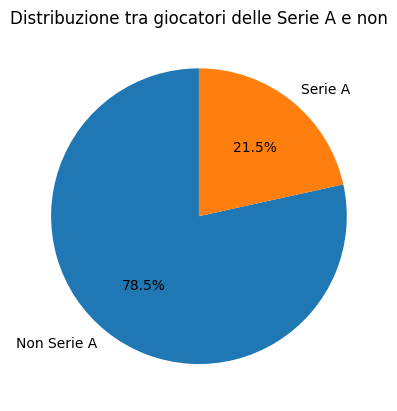

,competition_id,goals,assists,red_cards,yellow_cards,minutes_played,position,height_in_cm,eta,ritirato,Categoria
player_id,,,,,,,,,,,
10,IT1,48,24,0,19,8808,2,184.0,45,0,Serie A
26,L1,0,0,2,4,13508,3,190.0,43,0,Non Serie A
65,GB1,38,13,1,11,8788,2,181.0,42,0,Non Serie A
80,L1,0,0,0,0,1080,3,194.0,42,0,Non Serie A
123,L1,0,1,0,0,427,0,184.0,43,0,Non Serie A
...,...,...,...,...,...,...,...,...,...,...,...
1108145,FR1,1,1,0,6,1481,0,173.0,19,1,Non Serie A
1111776,FR1,0,0,0,0,88,2,180.0,18,1,Non Serie A
1111777,FR1,0,0,0,0,45,0,185.0,19,1,Non Serie A


In [121]:
# adesso vogliamo mantenere solo i campi relativi ai campionati di interesse per il confronto, cioe i 5 maggiori campionati europeri, serire a, bundes, premier, liga, ligue1.
# per fare questo manteniamo le righe con i codici dei campionati di interesse

df_finale = df_finale[df_finale['competition_id'].isin(['IT1', 'ES1', 'FR1', 'L1', 'GB1'])]

# creiamo la colonna categoria in cui etichettiamo il campionato in serire a e non 

df_finale['Categoria'] = df_finale['competition_id'].apply(lambda x: 'Serie A' if x == 'IT1' else 'Non Serie A')
 
# Crea il grafico a torta basato sulla nuova colonna "Categoria" per vedere lo sbilanciamento tra le classi
count_per_category = df_finale['Categoria'].value_counts()

print(count_per_category)
# Crea il grafico a torta
count_per_category.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Distribuzione tra giocatori delle Serie A e non')
plt.ylabel('')  # Rimuove l'etichetta sull'asse y
#plt.savefig("../../../images/classificazione_camp/bilanc_campionati.png")
plt.show()


df_finale

In [122]:
# andiamo a sostituire 
df_finale['Categoria'] = df_finale['competition_id'].apply(lambda x: 1 if x == 'IT1' else 0)

df_finale = df_finale.drop(['competition_id'], axis=1)




C:\Users\nicol\AppData\Local\Temp\ipykernel_2856\672521998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finale['Categoria'] = df_finale['competition_id'].apply(lambda x: 1 if x == 'IT1' else 0)


In [123]:
df_finale = df_finale[df_finale['position'] != 'Missing']

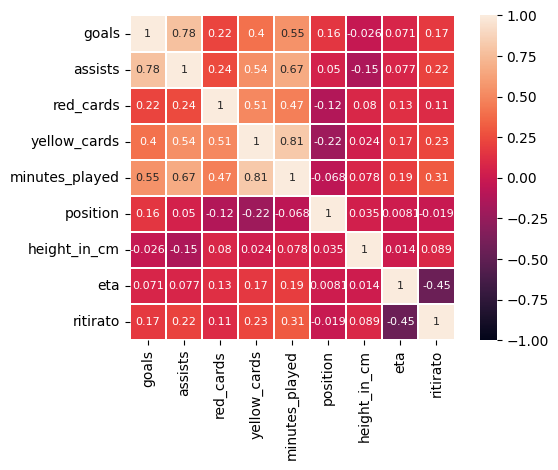

In [125]:

# andiamo a creare un dataframe con le colonne che ci servono per studiare la correlazione tra le feature. Togliamo anche quei campi che non sono nuerici
df_corr = df_finale[[
    'goals',
    'assists',
    'red_cards',
    'yellow_cards', 
    'minutes_played',
    'position',
    'height_in_cm',
    'eta',
    'ritirato']]

# vediamo la correlazione tra le feature 

annot_kws = {"size": 8}

sns.heatmap(df_corr.corr(), vmax=1, vmin=-1,square=True, annot=True, linewidths=.2, cbar=True, annot_kws=annot_kws)

plt.tight_layout()
#plt.savefig("../../images/classificazione_camp/correlazione_camp.png")
plt.show()




In [126]:
# togliamo minutes played perche altamente correlato

df_finale = df_finale.drop(['minutes_played'], axis=1)


In [140]:
# visto che il dataset è sbilanciato andiamo in questo codice a fare downsampling, diminuendo la classe maggioritaria fino a portarla a bilanciamento

# Dividi il DataFrame in due parti basate su "competition_id"
df_ita = df_finale[df_finale['Categoria'] == 1]
df_nonita = df_finale[df_finale['Categoria'] == 0]
 
# Esegui il sample delle righe da df_nonita in modo che siano pari al numero di righe in df_ita
df_nonita_sampled = df_nonita.sample(n=len(df_ita), replace=True, random_state=42)
 
# Combina i due DataFrame
balanced_df = pd.concat([df_ita, df_nonita_sampled])

 
# Salva il DataFrame ridotto

joblib.dump(balanced_df, 'dataframe_class_pos_down.joblib')


,goals,assists,red_cards,yellow_cards,position,height_in_cm,eta,ritirato,Categoria
player_id,,,,,,,,,
10,48,24,0,19,2,184.0,45,0,1
735,0,1,0,1,0,178.0,42,0,1
1161,0,1,0,1,0,178.0,50,0,1
2865,13,28,0,60,0,182.0,39,0,1
2904,0,2,2,11,0,184.0,44,0,1
...,...,...,...,...,...,...,...,...,...
148208,0,0,0,2,0,189.0,28,0,0
37501,43,9,0,5,2,187.0,36,0,0
45395,7,5,0,12,1,180.0,35,0,0


Categoria
1    1571
0    1571
Name: count, dtype: int64


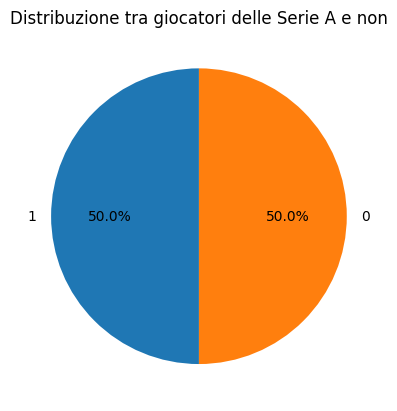

,goals,assists,red_cards,yellow_cards,position,height_in_cm,eta,ritirato,Categoria
player_id,,,,,,,,,
10,48,24,0,19,2,184.0,45,0,1
735,0,1,0,1,0,178.0,42,0,1
1161,0,1,0,1,0,178.0,50,0,1
2865,13,28,0,60,0,182.0,39,0,1
2904,0,2,2,11,0,184.0,44,0,1
...,...,...,...,...,...,...,...,...,...
148208,0,0,0,2,0,189.0,28,0,0
37501,43,9,0,5,2,187.0,36,0,0
45395,7,5,0,12,1,180.0,35,0,0


In [129]:
# PENSO DA LEVARE


# Crea il grafico a torta basato sulla nuova colonna "Categoria"
count_per_category = balanced_df['Categoria'].value_counts()

print(count_per_category)
# Crea il grafico a torta
count_per_category.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Distribuzione tra giocatori delle Serie A e non')
plt.ylabel('')  # Rimuove l'etichetta sull'asse y
plt.show()

balanced_df

In [141]:
# visto che il dataset è sbilanciato andiamo in questo codice a fare upsampling usando la tecnica di generazione di dati sintetici: SMOTE


X = df_finale.drop('Categoria', axis=1)
y = df_finale['Categoria']
 
# Applica SMOTE all'insieme di dati di training
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
 
# Crea un nuovo DataFrame con i dati resampled
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Categoria'] = y_resampled

# salviamo il dataframe

joblib.dump(df_resampled, 'dataframe_class_pos_SMOTE.joblib')


,goals,assists,red_cards,yellow_cards,position,height_in_cm,eta,ritirato,Categoria
0,48,24,0,19,2.0,184.000000,45,0,1
1,0,0,2,4,3.0,190.000000,43,0,0
2,38,13,1,11,2.0,181.000000,42,0,0
3,0,0,0,0,3.0,194.000000,42,0,0
4,0,1,0,0,0.0,184.000000,43,0,0
...,...,...,...,...,...,...,...,...,...
11437,0,0,0,0,2.0,175.826962,31,0,1
11438,9,7,1,8,1.625059,171.124822,32,0,1
11439,0,0,1,3,0.0,184.491996,43,0,1
11440,0,0,0,4,0.0,184.000000,43,0,1


Categoria
1    5721
0    5721
Name: count, dtype: int64


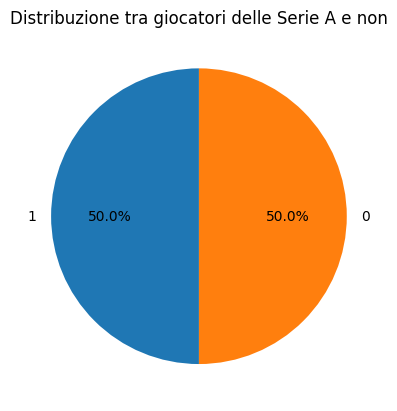

,goals,assists,red_cards,yellow_cards,position,height_in_cm,eta,ritirato,Categoria
0,48,24,0,19,2.0,184.000000,45,0,1
1,0,0,2,4,3.0,190.000000,43,0,0
2,38,13,1,11,2.0,181.000000,42,0,0
3,0,0,0,0,3.0,194.000000,42,0,0
4,0,1,0,0,0.0,184.000000,43,0,0
...,...,...,...,...,...,...,...,...,...
11437,0,0,0,16,0.0,187.528521,23,1,1
11438,30,33,2,43,1.527319,183.000000,30,0,1
11439,2,1,0,8,1.640215,175.000000,20,0,1
11440,0,0,0,9,0.0,184.432526,39,0,1


In [139]:
# PENSO SI PUO LEVARE

# Crea il grafico a torta basato sulla nuova colonna "Categoria"
count_per_category = df_resampled['Categoria'].value_counts()

print(count_per_category)
# Crea il grafico a torta
count_per_category.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Distribuzione tra giocatori delle Serie A e non')
plt.ylabel('')  # Rimuove l'etichetta sull'asse y
plt.show()


